## Analysis of Dataset Cards by Country

### Campare the word counts of each dataset card

In [3]:
import pandas as pd
import re

langs = ['en', 'ja', 'ko', 'zh']

for lang in langs:
    dataset_cards_path = f"data/dataset_card/dataset_cards_{lang}.csv"
    huggingface_datasets_path = f"data/dataset_meta/dataset_meta_{lang}.csv"
    output_path = f"data/dataset_card/huggingface_datasets_{lang}_filtered.csv"

    selected_columns = ["id", "created_at", "downloads_alltime", "tasks", "arxiv_id"]
    huggingface_datasets =  pd.read_csv(huggingface_datasets_path)
    huggingface_datasets =  huggingface_datasets[huggingface_datasets['language_category'] == "mono"]
    huggingface_datasets = huggingface_datasets.sort_values(by="downloads_alltime", ascending=False).reset_index(drop=True)[:700]
    huggingface_datasets = huggingface_datasets[selected_columns]
    dataset_cards = pd.read_csv(dataset_cards_path)

    def calculate_word_count(card_text):
        if pd.isna(card_text) or not isinstance(card_text, str):
            return 0  
        return len(card_text.split())

    required_sections = [
        "Dataset Description",
        "Dataset Structure",
        "Dataset Creation",
        "Considerations for Using the Data",
        "Additional Information"
    ]

    def check_follow_template(card_text):
        if pd.isna(card_text) or not isinstance(card_text, str):
            return 0  
        section_presence = [bool(re.search(section, card_text, re.IGNORECASE)) for section in required_sections]
        return int(all(section_presence))

    dataset_cards["dataset_card"] = dataset_cards["markdown_content"]
    dataset_cards["total_word_cnt"] = dataset_cards["dataset_card"].apply(calculate_word_count)
    dataset_cards["follow_template"] = dataset_cards["dataset_card"].apply(check_follow_template)
    dataset_cards_filtered = dataset_cards[["dataset_id", "yaml_metadata", "dataset_card", "total_word_cnt", "follow_template"]]

    merged_df = huggingface_datasets.merge(
        dataset_cards_filtered,
        left_on="id",
        right_on="dataset_id",
        how="left"
    )

    merged_df.drop(columns=["dataset_id"], inplace=True)
    merged_df.to_csv(output_path, index=False)

    print(merged_df.shape)
merged_df.head()

(554, 9)
(366, 9)
(406, 9)
(287, 9)


,id,created_at,downloads_alltime,tasks,arxiv_id,yaml_metadata,dataset_card,total_word_cnt,follow_template
0,ceval/ceval-exam,2023-05-16 01:47:44,9608072,"text-classification, multiple-choice, question...",2305.08322,"{""license"": ""cc-by-nc-sa-4.0"", ""task_categorie...",C-Eval is a comprehensive Chinese evaluation s...,210,0
1,haonan-li/cmmlu,2023-06-25 16:37:44,3105652,"multiple-choice, question-answering",2306.09212,"{""license"": ""cc-by-nc-4.0"", ""task_categories"":...",# CMMLU: Measuring massive multitask language ...,389,0
2,clue/clue,2022-03-02 23:29:22,193446,"text-classification, multiple-choice, topic-cl...",2004.05986,"{""annotations_creators"": [""other""], ""language_...","# Dataset Card for ""clue""\n\n## Table of Conte...",936,1
3,Skywork/SkyPile-150B,2023-10-23 12:55:10,145252,text-generation,NaN,"{""task_categories"": [""text-generation""], ""lang...",# SkyPile-150B \n\n## Dataset Summary\nSkyPile...,474,0
4,ikala/tmmluplus,2023-12-22 19:12:13,133758,question-answering,NaN,"{""license"": ""mit"", ""license_name"": ""mit"", ""tas...",# TMMLU+ : Large scale traditional chinese mas...,829,0


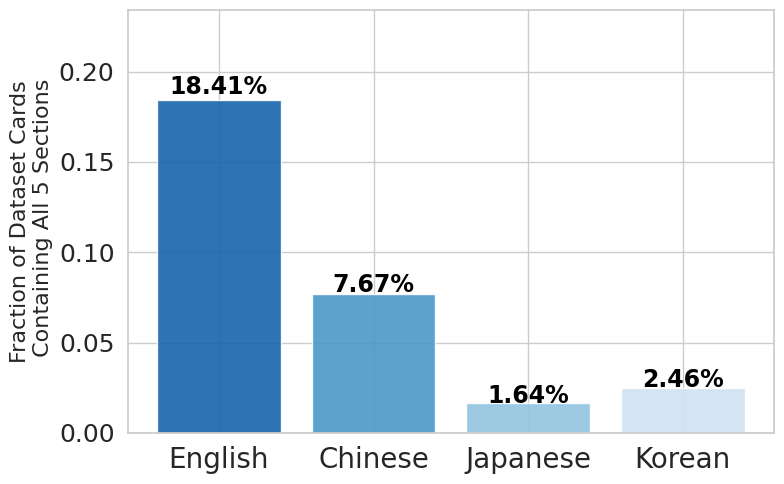

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

langs = ['en', 'zh', 'ja', 'ko']
lang_labels = ['English', 'Chinese', 'Japanese', 'Korean']  
lang_means = []

for lang in langs:
    output_path = output_path = f"data/dataset_card/huggingface_datasets_{lang}_filtered.csv"
    merged_df = pd.read_csv(output_path)

    mean_follow_template = merged_df["follow_template"].mean()
    lang_means.append(mean_follow_template)

y_max = min(1, max(lang_means) + 0.05)  

plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")

bar_colors = sns.color_palette("Blues_r", n_colors=len(langs))
bars = plt.bar(lang_labels, lang_means, capsize=0, color=bar_colors, alpha=0.9)  

plt.ylabel('Fraction of Dataset Cards\n Containing All 5 Sections', fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)
plt.ylim(0, y_max)  

for bar, v in zip(bars, lang_means):
    height = bar.get_height()
    offset = height * 0.02 
    plt.text(bar.get_x() + bar.get_width() / 2, height + offset, f"{v:.2%}", 
             ha='center', fontsize=17, fontweight='bold', color="black")

plt.tight_layout()
plt.savefig('./figures/follow_template_comparison.pdf', facecolor='white', edgecolor='none', dpi=300)

# 🔹 그래프 출력
plt.show()


### Compare the fraction of dataset cards that contain all five required sections

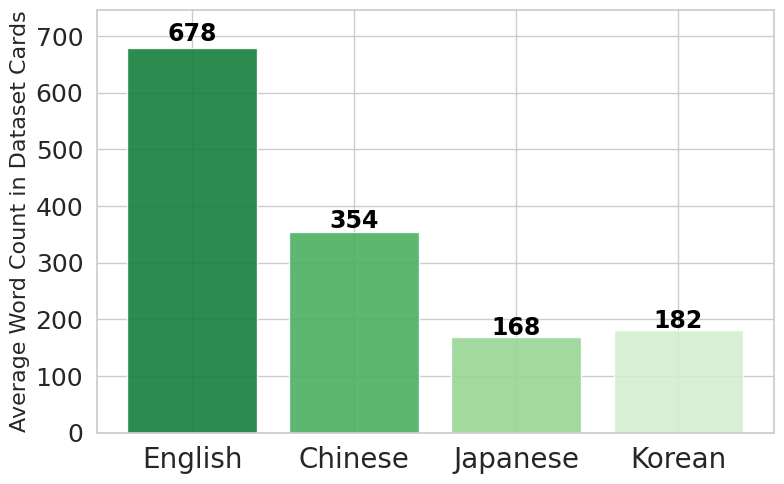

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

langs = ['en', 'zh', 'ja', 'ko']
lang_labels = ['English', 'Chinese', 'Japanese', 'Korean']  
lang_means = []

for lang in langs:
    output_path = output_path = f"data/dataset_card/huggingface_datasets_{lang}_filtered.csv"
    merged_df = pd.read_csv(output_path)

    mean_word_count = merged_df["total_word_cnt"].mean()
    lang_means.append(mean_word_count)

y_max = max(lang_means) * 1.1  

plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")

bar_colors = sns.color_palette("Greens_r", n_colors=len(langs))
bars = plt.bar(lang_labels, lang_means, capsize=0, color=bar_colors, alpha=0.9)  

plt.ylabel('Average Word Count in Dataset Cards', fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)
plt.ylim(0, y_max)  

for bar, v in zip(bars, lang_means):
    height = bar.get_height()
    offset = height * 0.02  
    plt.text(bar.get_x() + bar.get_width() / 2, height + offset, f"{int(v):,}", 
             ha='center', fontsize=17, fontweight='bold', color="black")

plt.tight_layout()
plt.savefig('./figures/dataset_card_word_count_comparison.pdf', facecolor='white', edgecolor='none', dpi=300)
plt.show()

## Overall Analysis of Dataset Cards

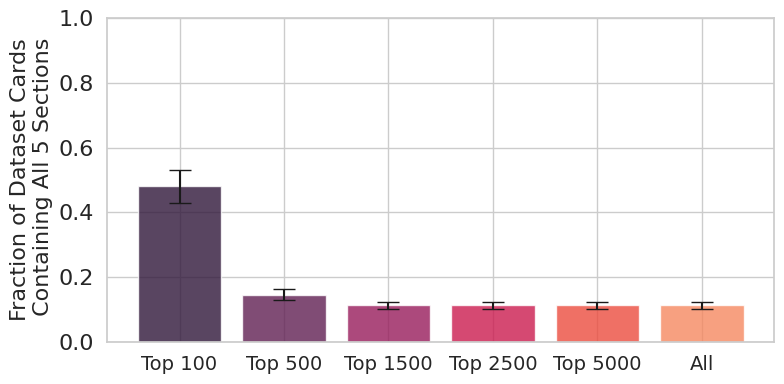

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

merged_df = merged_df.sort_values(by="downloads_alltime", ascending=False)
group_sizes = [100, 500, 1500, 2500, 5000, None, 0]
labels = [f'Top {size}' for size in group_sizes[:-2]] + ['All', 'Downloads=0']

def calculate_mean_sem(dataframe, group_sizes):
    means = [dataframe.head(size)["follow_template"].mean() for size in group_sizes[:-2]]
    stderrs = [dataframe.head(size)["follow_template"].sem() for size in group_sizes[:-2]]
    means.append(dataframe["follow_template"].mean())  
    stderrs.append(dataframe["follow_template"].sem())
    means.append(dataframe[dataframe["downloads_alltime"] == 0]["follow_template"].mean())  
    stderrs.append(dataframe[dataframe["downloads_alltime"] == 0]["follow_template"].sem())
    return means, stderrs

means, stderrs = calculate_mean_sem(merged_df, group_sizes)
plt.rcParams['font.family'] = 'serif'
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
bar_colors = sns.color_palette("rocket", n_colors=len(labels))
plt.bar(labels, means, yerr=stderrs, capsize=8, color=bar_colors, alpha=0.8)
plt.ylabel('Fraction of Dataset Cards\n Containing All 5 Sections', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=16)
plt.ylim(0, 1) 
plt.tight_layout()
plt.show()


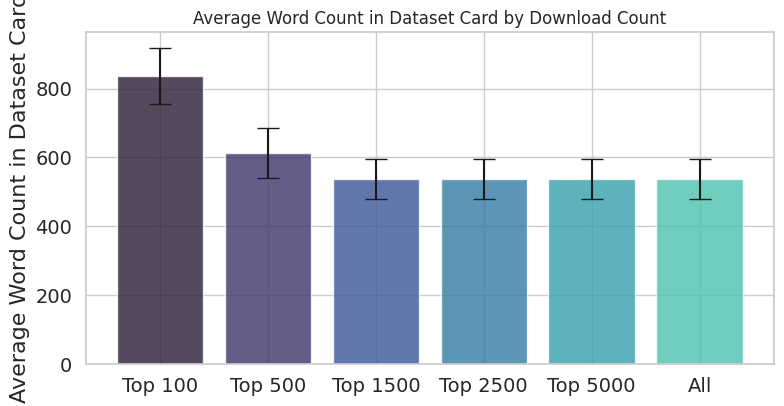

In [10]:
def calculate_word_count_mean_sem(dataframe, group_sizes):
    means = [dataframe.head(size)["total_word_cnt"].mean() for size in group_sizes[:-2]]
    stderrs = [dataframe.head(size)["total_word_cnt"].sem() for size in group_sizes[:-2]]
    means.append(dataframe["total_word_cnt"].mean()) 
    stderrs.append(dataframe["total_word_cnt"].sem())
    means.append(dataframe[dataframe["downloads_alltime"] == 0]["total_word_cnt"].mean()) 
    stderrs.append(dataframe[dataframe["downloads_alltime"] == 0]["total_word_cnt"].sem())
    return means, stderrs

word_means, word_stderrs = calculate_word_count_mean_sem(merged_df, group_sizes)

plt.figure(figsize=(8, 4))
bar_colors = sns.color_palette("mako", n_colors=len(labels))
plt.bar(labels, word_means, yerr=word_stderrs, capsize=8, color=bar_colors, alpha=0.8)
plt.ylabel('Average Word Count in Dataset Card', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.title("Average Word Count in Dataset Card by Download Count")
plt.show()


/tmp/ipykernel_245162/453495196.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=section_avg_ratios.index, y=section_avg_ratios.values, palette="magma")


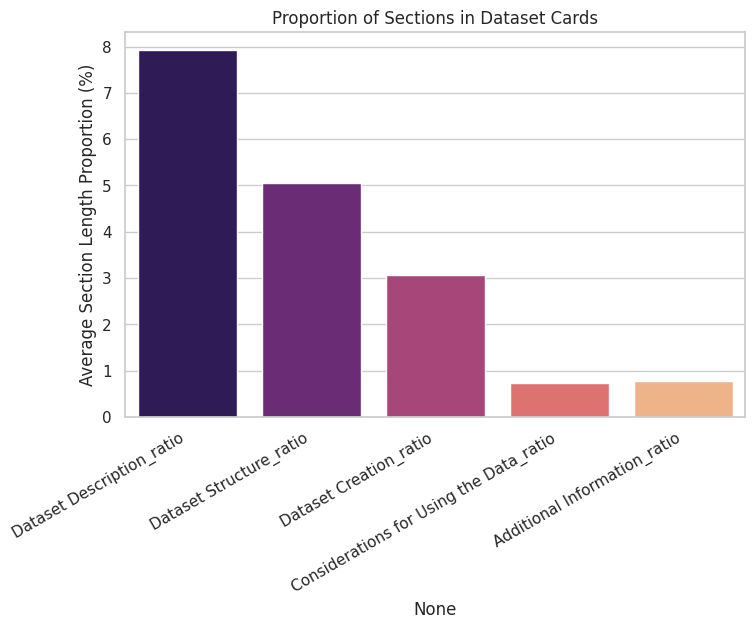

/tmp/ipykernel_245162/453495196.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_section_ratios = merged_df.groupby("downloads_bins")[[f"{section}_ratio" for section in sections]].mean() * 100


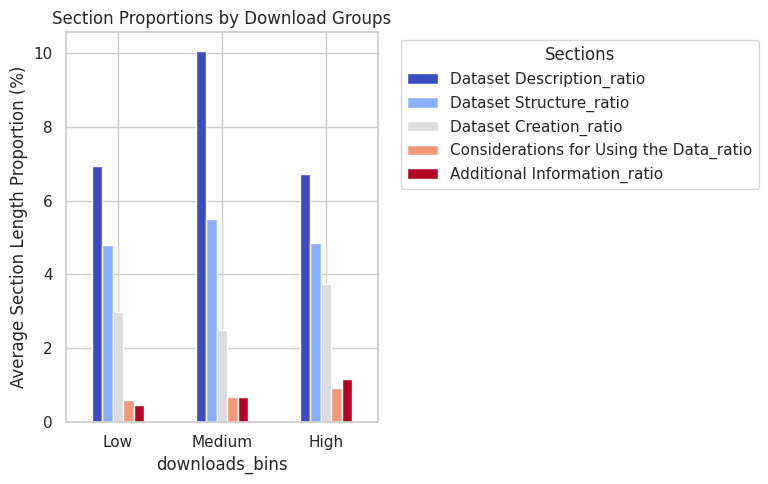

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

sections = [
    "Dataset Description",
    "Dataset Structure",
    "Dataset Creation",
    "Considerations for Using the Data",
    "Additional Information"
]

def count_section_words(text, section):
    if pd.isna(text) or not isinstance(text, str):
        return 0 
    match = re.search(f"(?<={section}).*?(?=Dataset Description|Dataset Structure|Dataset Creation|Considerations for Using the Data|Additional Information|$)", 
                      text, re.IGNORECASE | re.DOTALL)
    return len(match.group().split()) if match else 0

for section in sections:
    merged_df[section] = merged_df["dataset_card"].apply(lambda text: count_section_words(text, section))

for section in sections:
    merged_df[f"{section}_ratio"] = merged_df[section] / merged_df["total_word_cnt"]

section_avg_ratios = merged_df[[f"{section}_ratio" for section in sections]].mean() * 100  # 백분율 변환

plt.figure(figsize=(8, 5))
sns.barplot(x=section_avg_ratios.index, y=section_avg_ratios.values, palette="magma")
plt.ylabel("Average Section Length Proportion (%)")
plt.xticks(rotation=30, ha="right")
plt.title("Proportion of Sections in Dataset Cards")
plt.show()

merged_df["downloads_bins"] = pd.qcut(merged_df["downloads_alltime"], q=3, labels=["Low", "Medium", "High"])
grouped_section_ratios = merged_df.groupby("downloads_bins")[[f"{section}_ratio" for section in sections]].mean() * 100

grouped_section_ratios.plot(kind="bar", figsize=(8, 5), colormap="coolwarm")
plt.ylabel("Average Section Length Proportion (%)")
plt.xticks(rotation=0)
plt.title("Section Proportions by Download Groups")
plt.legend(title="Sections", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

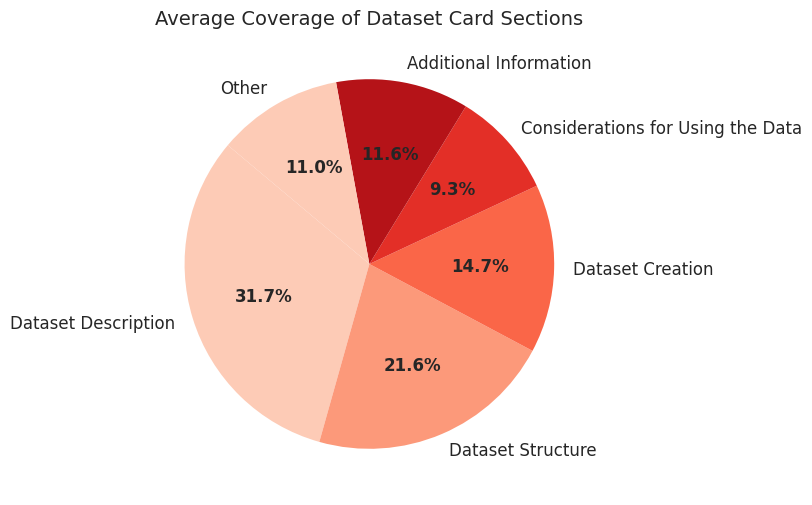

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# 섹션 목록
section_list = [
    'Dataset Description',
    'Dataset Structure',
    'Dataset Creation',
    'Considerations for Using the Data',
    'Additional Information',
    'Other'
]

section_avg_ratios = [merged_df[f"{section}_ratio"].mean() * 100 for section in section_list]

fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.cm.Reds(range(50, 250, 40))  

wedges, texts, autotexts = ax.pie(
    section_avg_ratios, 
    labels=section_list, 
    autopct=lambda p: f'{p:.1f}%',  
    colors=colors,
    startangle=140,
    wedgeprops={'edgecolor': 'none'}
)

plt.setp(autotexts, size=12, weight="bold")
plt.setp(texts, size=12)
ax.set_title("Average Coverage of Dataset Card Sections", fontsize=14)
plt.show()


               Section                        Subsection   Coverage
0  Dataset Description                   Dataset Summary  22.860963
1  Dataset Description  Supported Tasks and Leaderboards  12.433155
2  Dataset Description                         Languages  35.427807
3    Dataset Structure                    Data Instances  16.176471
4    Dataset Structure                       Data Fields  18.983957


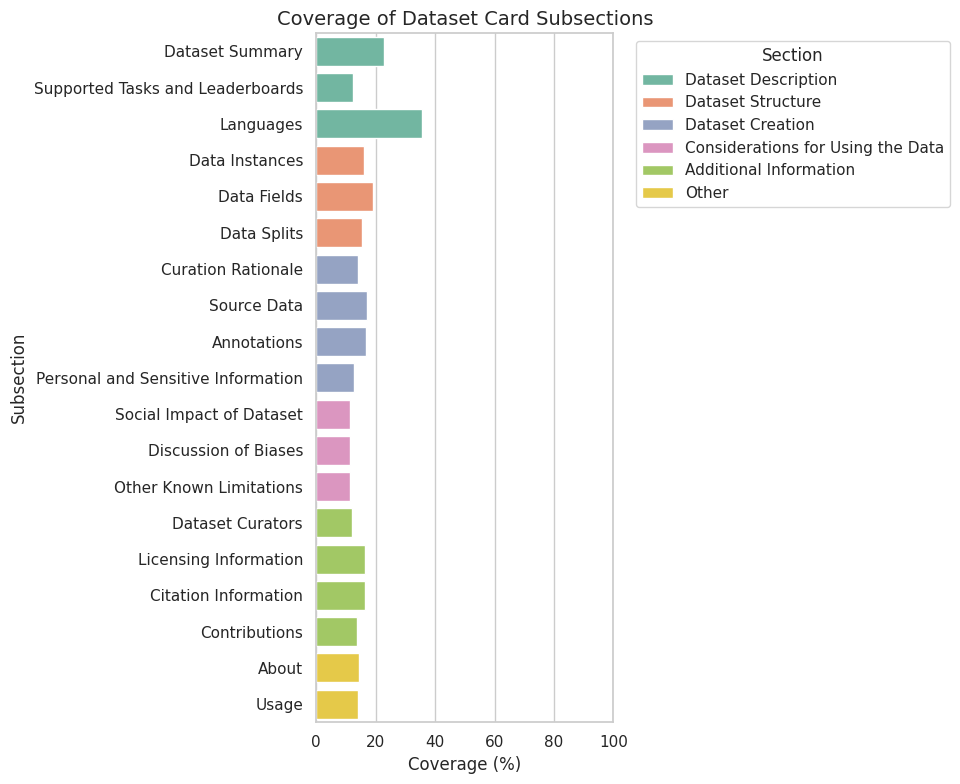

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

section_type_dict = {
    'Dataset Description': ['Dataset Summary', 'Supported Tasks and Leaderboards', 'Languages'],
    'Dataset Structure': ['Data Instances', 'Data Fields', 'Data Splits'],
    'Dataset Creation': ['Curation Rationale', 'Source Data', 'Annotations', 'Personal and Sensitive Information'],
    'Considerations for Using the Data': ['Social Impact of Dataset', 'Discussion of Biases', 'Other Known Limitations'],
    'Additional Information': ['Dataset Curators', 'Licensing Information', 'Citation Information', 'Contributions'],
    'Other': ['About', 'Usage']
}

subsection_coverage = []
total_datasets = len(merged_df) 

for section, subsections in section_type_dict.items():
    for subsection in subsections:
        count = merged_df["dataset_card"].apply(lambda x: bool(re.search(rf"\b{subsection}\b", x, re.IGNORECASE)) if isinstance(x, str) else False).sum()
        coverage_ratio = (count / total_datasets) * 100  
        subsection_coverage.append({"Section": section, "Subsection": subsection, "Coverage": coverage_ratio})

subsection_df = pd.DataFrame(subsection_coverage)
print(subsection_df.head())

plt.figure(figsize=(10, 8))
sns.barplot(
    data=subsection_df,
    y="Subsection",
    x="Coverage",
    hue="Section",
    dodge=False,
    palette="Set2"
)

plt.xlabel("Coverage (%)", fontsize=12)
plt.ylabel("Subsection", fontsize=12)
plt.title("Coverage of Dataset Card Subsections", fontsize=14)
plt.xlim(0, 100)
plt.legend(title="Section", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
